In [1]:
from google.colab import drive # remove the cell if not using colab
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
base_path = Path('/content/drive/MyDrive/data') # change path here!

# Klasyfikacja pasażerów Titanica
Po wysłaniu raportu pozostało już tylko czekać. Dni mijały, ale w końcu telefon zadzwonił. Okazało się, że po konsultacji Twojego raportu z najbardziej doświadczonymi specjalistami w dziedzinie, zleceniodawca zdecydował się powierzyć Ci dalszą część tajemniczego zadania. Chodzi oczywiście o... **stworzenie modelu przewidującego szanse przeżycia katastrofy Titanica**.

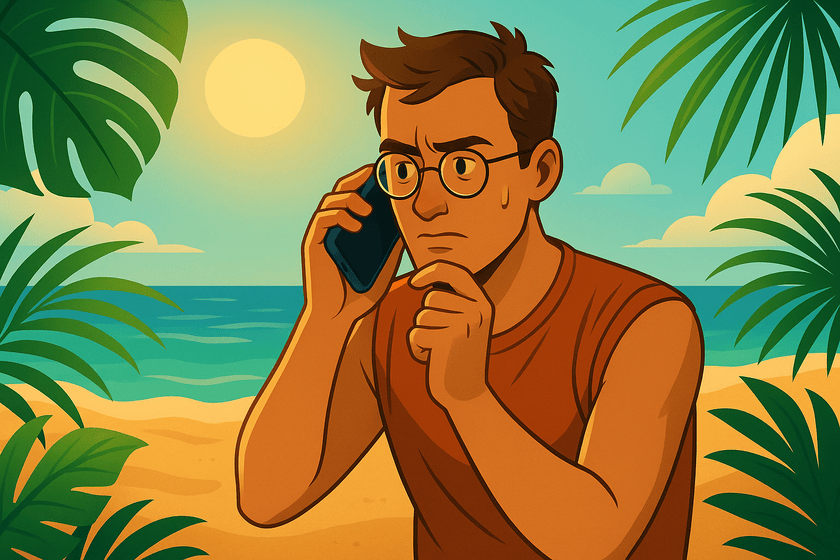

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

Trochę dużo tych importów xD <br>
Also, po ostatnim zadaniu zapisałem sobie przetworzoną ramkę do nowego pliku, który poniżej właśnie pobieram.<br>
Słowem wstępu, po review mojego zadania w poprzednim tygodniu, zdecydowałem się dodać jeszcze kolumnę Relatives, bo wyglądała na dobre rozwiązanie u jednej z osób, której oceniałem zadanie oraz zredukowałem wpływ outlier'ów w kolumnie Fare logarytmując całą kolumnę, bo sam dopiero zwróciłem na to uwagę jak jedna z osób poruszyła ten problem. <br>
Co do moich własnych obserwacji jeszcze sprzed review, to na ogół uważam swoje obserwacje za przydatne do modelu. Mam na myśli takie obserwacje jak:
- wyraźny podział pomiędzy osobami poniżej a powyżej 13 lat u mężczyzn (dlatego finalnie nie rozszerzyłem kolumny Is_child na teen, adult, senior itd.).
- mniejsza wartość SibSp dawała większe szanse na przeżycie. Dla Parch wpływ ten był trochę mniejszy jednak wciąż zauważalny, stąd zdecydowałem się połączyć te kolumny w Relatives jak wspomniałem wcześniej.
- Niższa wartość Pclass = lepsze szanse przeżycia *for obvious reasons*
- wyższe Fare tylko pośrednio (przez większą cenę wraz z lepszą klasą) wpływa na przeżycie, stąd zredukowanie tej zmiennej przez logarytmowanie.

In [343]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns

learning_data = pd.read_csv(base_path / 'titanic_ml_dataset.csv', index_col='PassengerId')
learning_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Deck,Is_child,Relatives,log_Fare
PassengerId,,,,,,,,,,
1,0,3,1,22.0,1,0,0,0,1,2.110213
2,1,1,0,38.0,1,0,4,0,1,4.280593
3,1,3,0,26.0,0,0,0,0,0,2.188856
4,1,1,0,35.0,1,0,4,0,1,3.990834
5,0,3,1,35.0,0,0,1,0,0,2.202765


Powyżej próbka danych pobranych z mojego dysku :3 <br>
Poniżej przeprowadzona standaryzacja danych. Proces ten z reguły zapewnia, że jedna zmienna nie przeważy nad innymi tylko z powodu jej większych wartości i raczej pomaga modelom, które zastosowałem w tej pracy.

In [344]:
for x in learning_data.columns:
    if x == 'Survived':
        continue
    learning_data[x] = (learning_data[x] - learning_data[x].mean()) / learning_data[x].std()
learning_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Deck,Is_child,Relatives,log_Fare
PassengerId,,,,,,,,,,
1,0,0.826913,0.737281,-0.537894,0.432550,-0.473408,-1.401015,-0.318192,0.059127,-0.901854
2,1,-1.565228,-1.354813,0.554560,0.432550,-0.473408,1.277750,-0.318192,0.059127,1.336249
3,1,0.826913,-1.354813,-0.264781,-0.474279,-0.473408,-1.401015,-0.318192,-0.560660,-0.820757
4,1,-1.565228,-1.354813,0.349725,0.432550,-0.473408,1.277750,-0.318192,0.059127,1.037448
5,0,0.826913,0.737281,0.349725,-0.474279,-0.473408,-0.731324,-0.318192,-0.560660,-0.806415


Podział danych na wejściowe i wyjściowe modelu.

In [345]:
input_data = learning_data.drop(columns=['Survived'])
output_data = learning_data['Survived']

Podział na zbiór do trenowania oraz testowy. Ponadto na wstępie sprawdziłem już działanie DummyClassifier jako baseline w tym zadaniu. Skuteczność tego modelu w okolicy 50% raczej nie jest zaskoczeniem ...

In [346]:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, train_size=.8, shuffle=True)
model = DummyClassifier(strategy = 'uniform')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f"ROC AUC score: {roc_auc_score(y_test, y_pred):.2f}")

              precision    recall  f1-score   support

           0       0.58      0.50      0.54       104
           1       0.42      0.49      0.45        75

    accuracy                           0.50       179
   macro avg       0.50      0.50      0.49       179
weighted avg       0.51      0.50      0.50       179

[[52 52]
 [38 37]]
ROC AUC score: 0.50


Wybrane modele badałem sprawdzając wszystkie możliwe kombinacje dwóch wybranych hiperparametrów. Poniżej funkcje, które tym się zajmują. single_search zajmuje się zbadaniem konkretniej kombinacji, a z poziomu grid_search_function wywoływane jest single_search na wszystkich wartościach.

In [347]:
# funkcja do zbadania pojedynczej kombinacji z param_1 i param_2
def single_search(model, X_train, X_test, y_train, y_test, new_params=None):
    # aktualizacja wybranych parametrów modelu
    model.set_params(**new_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # wydobycie informacji z raportu, macierzy oraz o wyniku roc auc
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    roc_auc_val = roc_auc_score(y_test, y_pred)

    # utworzenie oraz przekształcenie wyjściowych ramek
    per_class_data = pd.DataFrame(report)
    accuracy_score = per_class_data['accuracy'].iloc[0]
    per_class_data.drop(columns=['macro avg', 'weighted avg', 'accuracy'], inplace=True)
    per_class_data = per_class_data.T
    global_data = pd.DataFrame(data=[[accuracy_score, roc_auc_val, tp, tn, fp, fn]], columns=['accuracy', 'roc_auc', 'TP', 'TN', 'FP', 'FN'])
    for key, val in new_params.items():
        per_class_data[key] = val
        global_data[key] = val
    return per_class_data, global_data

# funkcja do zbadania wszystkich możliwych kombinacji podanych parametrów param_1 i param_2
def grid_search_function(model, X_train, X_test, y_train, y_test, param_1_list, param_2_list):
    # inicjalizacja ramek
    per_class_dataFrame = pd.DataFrame([])
    global_dataFrame = pd.DataFrame([])

    param_1_name = list(param_1_list.keys())[0]
    param_2_name = list(param_2_list.keys())[0]
    param_1_vals = param_1_list[param_1_name]
    param_2_vals = param_2_list[param_2_name]

    # pętla do zbadania wszystkich kombinacji
    for a in param_1_vals:
        for b in param_2_vals:
            per_class_data, global_data = single_search(model, X_train, X_test, y_train, y_test,
                                                    new_params={param_1_name : a, param_2_name : b})
            # złączenie danych z resztą ramki
            per_class_dataFrame = pd.concat([per_class_dataFrame, per_class_data])
            global_dataFrame = pd.concat([global_dataFrame, global_data])

    # modyfikacja indeksu w obu ramkach
    per_class_dataFrame.reset_index(inplace=True)
    per_class_dataFrame.rename(columns={'index' : 'class_id'}, inplace=True)
    global_dataFrame.reset_index(drop=True, inplace=True)
    return per_class_dataFrame, global_dataFrame

Dalej mamy sekcję kodu do rysowania wykresów. Dobrałem myślę, że ładne kolorki, do list, z których korzystam wewnątrz plot_data. Funkcja ta służy do połączenia funkcji plot_per_class_data dla metryk, które wyliczone są dla każdej klasy Survived (0 i 1) osobno oraz funkcji plot_global_data dla metryk liczonych tylko raz.

In [370]:
# kolorki do wykresów
scatter_colors = ['darkred', 'darkorange', 'darkgreen', 'darkblue', 'indigo']
plot_colors = ['red', 'orange', 'green', 'blue', 'blueviolet']

# tworzenie jednego wykresu
def plot_data(data, x, y, chart, subplot_nr=1, subplots_shape=[1, 2], c_id='-1'):
    plt.subplot(subplots_shape[0], subplots_shape[1], subplot_nr)
    # jeśli jest podana klasa to mamy do czynienia z danymi per_class
    if c_id != '-1':
        data = data[data['class_id'] == c_id]
        plt.title(f"{y} vs {x} and {chart} for class {c_id}")
    else: # else dane globalne
        plt.title(f"{y} vs {x} and {chart}")

    # iterowanie po wszystkich unikalnych wartościach kolumny z legendy (nazwana chart)
    # np.: w KNN metryka: euclidean, cosine, manhattan
    for i, val in enumerate(data[chart].unique()):
        plot_data = data[data[chart] == val]
        plt.scatter(plot_data[x], plot_data[y], color=scatter_colors[i])
        plt.plot(plot_data[x], plot_data[y], color=plot_colors[i], label=f'{val} {chart}')

    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.grid(True)

# zbiór wykresów dla accuracy i roc auc
def plot_global_data(data, x, chart):
    plt.figure(figsize=(14, 4))
    plot_data(data, x, 'accuracy', chart, 1, [1, 2])
    plot_data(data, x, 'roc_auc', chart, 2, [1, 2])
    plt.show()

# zbiór wykresów dla precision, recall i f1
def plot_per_class_data(data, x, chart):
    plt.figure(figsize=(14, 12))
    plot_data(per_class_dataFrame, x, 'precision', chart, 1, [3, 2], '0')
    plot_data(per_class_dataFrame, x, 'precision', chart, 2, [3, 2], '1')
    plot_data(per_class_dataFrame, x, 'recall', chart, 3, [3, 2], '0')
    plot_data(per_class_dataFrame, x, 'recall', chart, 4, [3, 2], '1')
    plot_data(per_class_dataFrame, x, 'f1-score', chart, 5, [3, 2], '0')
    plot_data(per_class_dataFrame, x, 'f1-score', chart, 6, [3, 2], '1')
    plt.tight_layout()
    plt.show()


Badanie pierwszego modelu. Od razu wybrałem XGB, bo imo najfajniejszy. Z tego też powodu tutaj dobrałem największą liczbę kombinacji (razem 5*15) :)). Badana jest tutaj liczba estymatorów oraz wskaźnik learning_rate.

In [363]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    random_state=42
)
n_estimators = {'n_estimators' : [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400]}
learning_rate = {'learning_rate' : [0.01, 0.03, 0.05, 0.07, 0.09]}
per_class_dataFrame, global_dataFrame = grid_search_function(xgb_model, X_train, X_test, y_train, y_test, n_estimators, learning_rate)

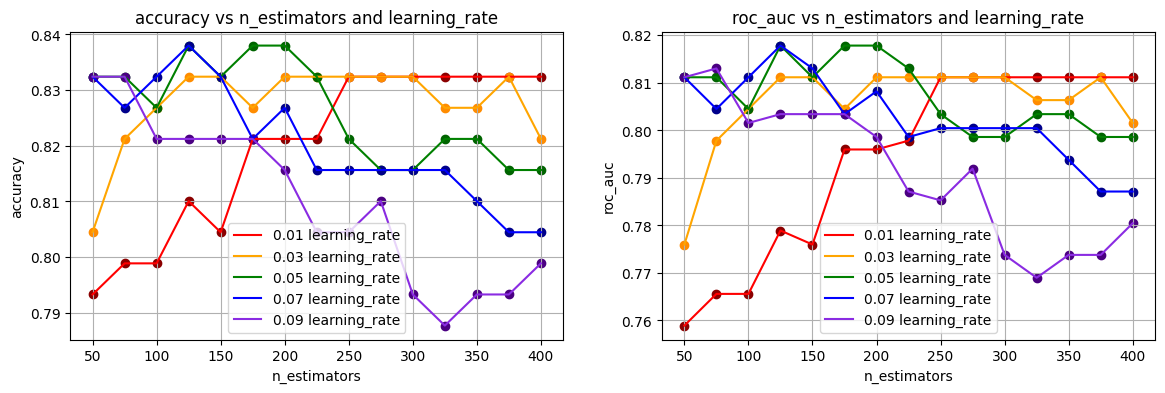

In [364]:
plot_global_data(global_dataFrame, 'n_estimators', 'learning_rate')

Powyżej wykresy dokładności oraz ROC AUC, a poniżej pozostałych metryk: precyzja, czułość, F1. Poniżej tych wykresów dzielę się obserwacjami, dla lepszego obrazu całości :)

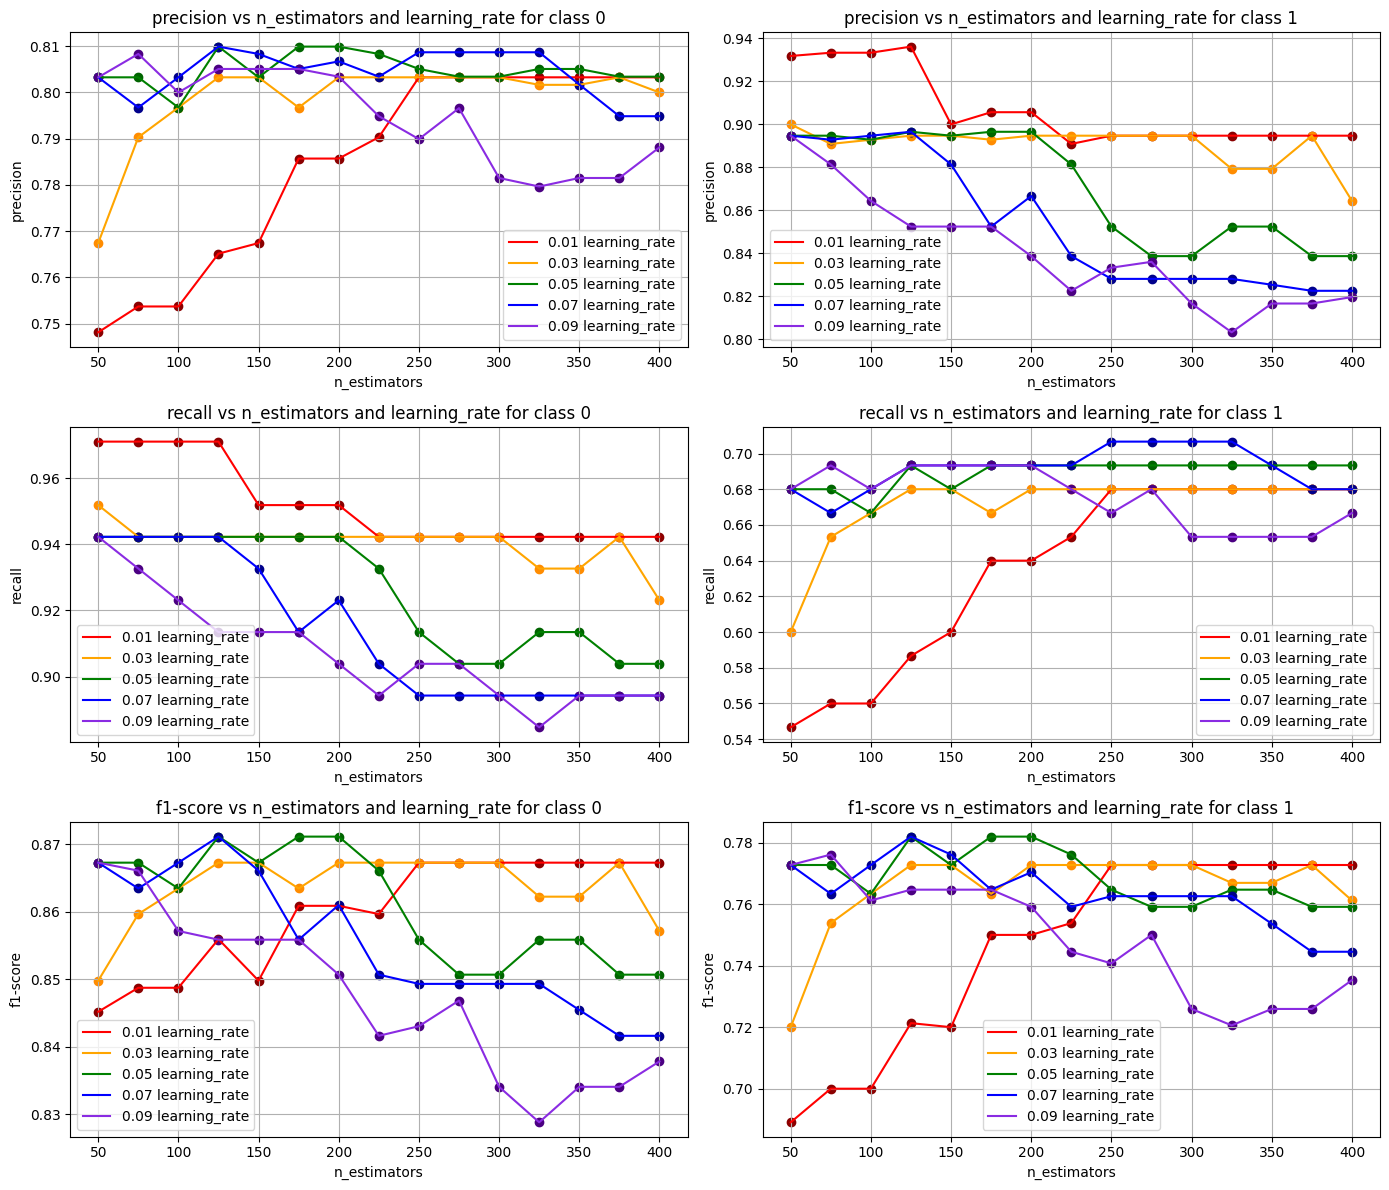

In [365]:
plot_per_class_data(per_class_dataFrame, 'n_estimators', 'learning_rate')

Ok, więc patrząc na powyższe wykresy zauważyć możemy na większości z nich, że model zdaje się działać odwrotnie przy niskiej oraz wysokiej wartości learning_rate. Dla niskiego najlepsza jest duża liczba estymatorów, dla wysokiego mała. <br>
Zgłębiając się w szczegóły można zauważyć m.in.: po wyniku ROC AUC oraz precyzji (dla klasy 1), że wraz z większą liczbą estymatorów model częściej przewiduje wartość 1, lecz równie częściej się myli. Jest to najbardziej szkodliwe w połączeniu z wysokim wskaźnikiem learnign_rate, dla którego obie omawiane metryki opadają. W przypadku niskiego learning_rate efekt ten nie jest tak zauważalny, gdyż tempo wzrostu ROC AUC przewyższa tempo spadku precyzji, co wskazuje w tym przypadku na 'tylko' minimalnie większą liczbę przypadków FP od TP. <br>
Obserwacja ta zdaje się przemawiać bardziej na korzyść modelu z niskim wskaźnikiem learning_rate oraz dużą liczbą estymatorów, co znajduje potwierdzenie m.in.: w metryce F1, która działa jako średnia harmoniczna precyzji oraz czułości. Zarówno w kontekście klasy 0 jak i 1 jakość modelu rośnie wraz z liczbą estymatorów przy niskim learning_rate.

---
Kolejny model to KNN :). Badanie tego modelu obejmuje metrykę odległości oraz rozmiar sąsiedztwa.

In [354]:
knn = KNeighborsClassifier(
    n_neighbors=3,
    metric='euclidean'
)
n_neighbors = {'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8]}
metric = {'metric' : ['euclidean', 'cosine', 'manhattan']}
per_class_dataFrame, global_dataFrame = grid_search_function(knn, X_train, X_test, y_train, y_test, n_neighbors, metric)

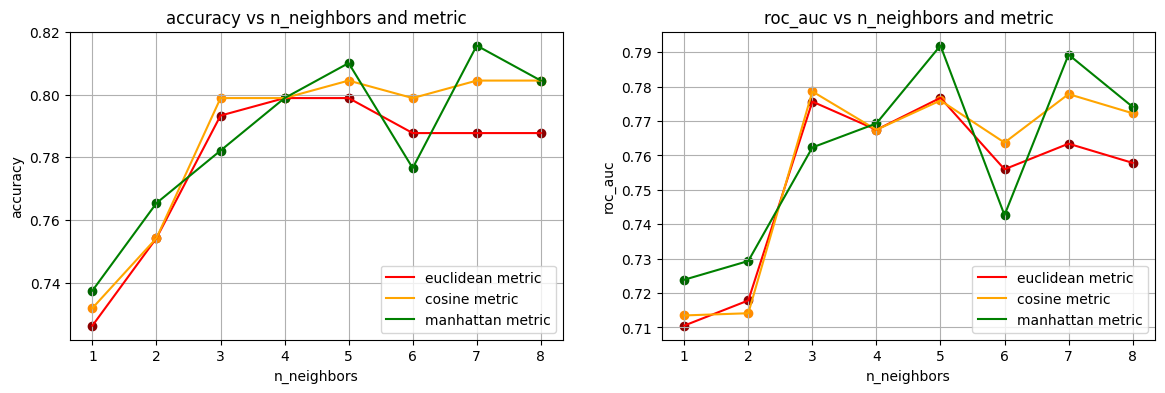

In [355]:
plot_global_data(global_dataFrame, 'n_neighbors', 'metric')

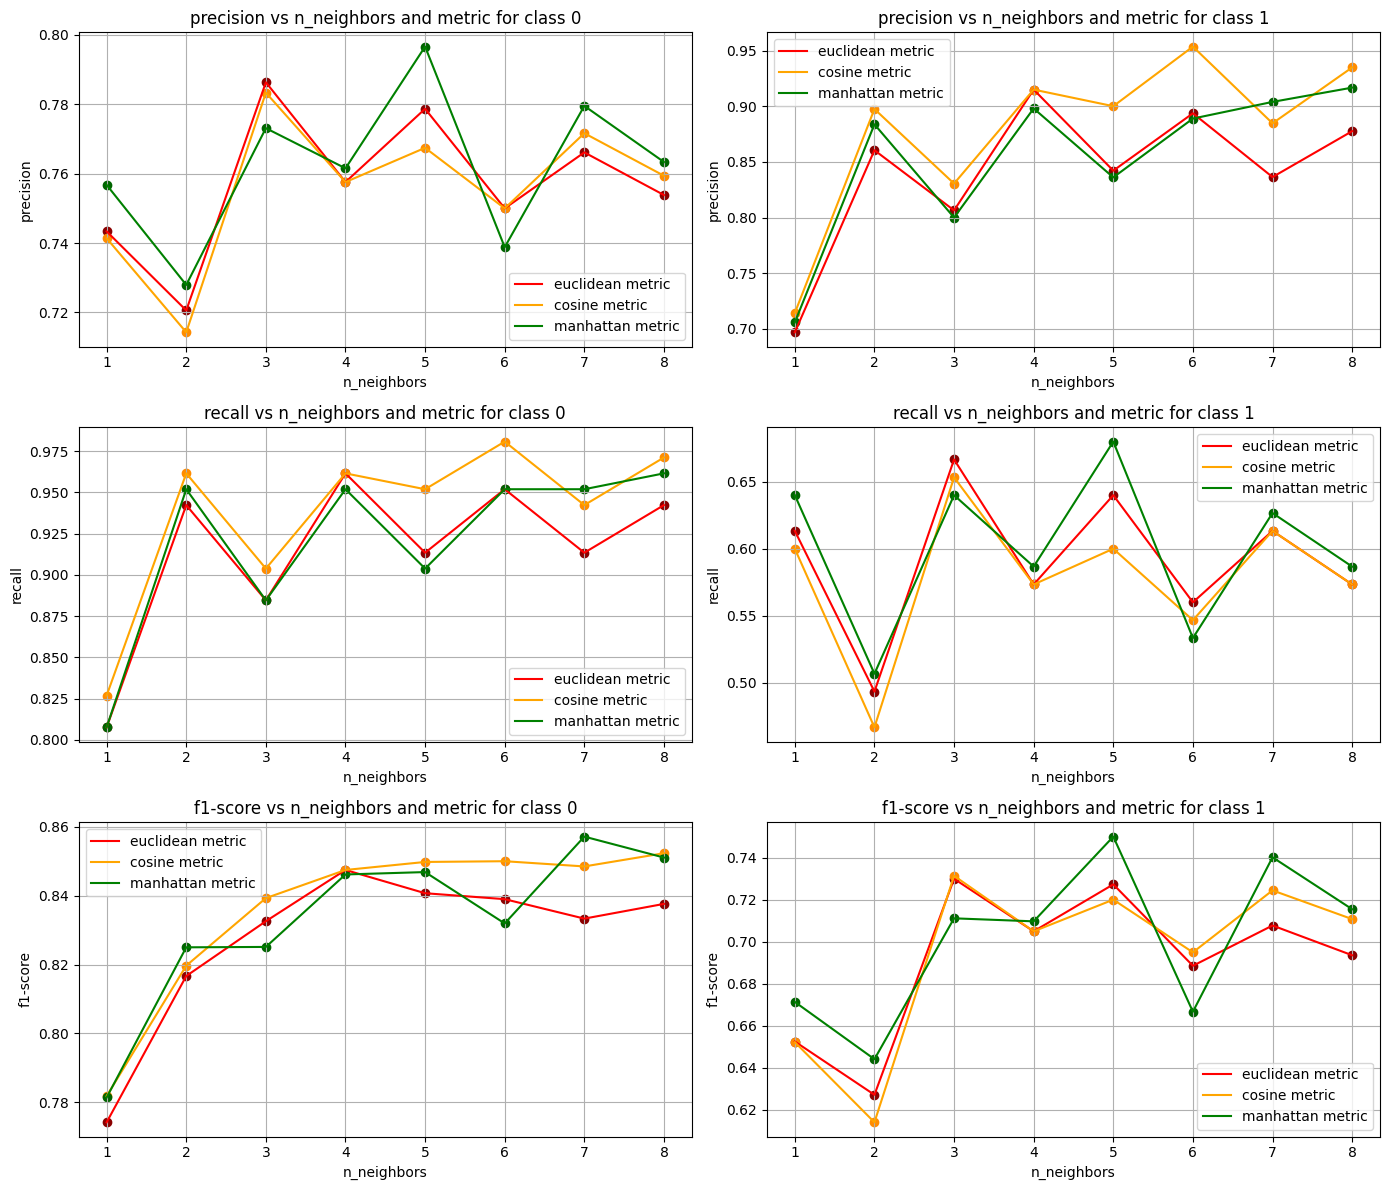

In [356]:
plot_per_class_data(per_class_dataFrame, 'n_neighbors', 'metric')

Z powyższych wizualizacji zauważyć można, że dobór metryki odległości okazał się mało istotny dla jakości modelu. Większy wływ zdaje się mieć rozmiar sąsiedztwa. Szczególnie zauważalny jest wpływ zbyt małego sąsiedztwa. W przypadku dużego sąsiedztwa nie widoczna jest tendencja wzrostowa ani spadkowa, dlatego najlepszym wyborem w wyważeniu wszystkich metryk może być dobranie sąsiedztwa o rozmiarze 3 lub 4.

---
Kolejny model to RandomForest ... taka lepsza wersja DecisionTree. Dla niewtajemiczonych, RandomForest to nic innego jak "las" o wielkości n_estimators złożony z drzewek typu DecisionTree. Spośród tego "lasu" najlepsze rozwiązanie wybierane jest jako średnia (w regresji) lub po prostu najlepsze (w klasyfikacji). Tutaj badałem głębię drzew oraz ich liczbę.

In [357]:
forest_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    random_state=42
)
n_estimators = {'n_estimators' : [50, 100, 150, 200, 250, 300, 350]}
max_depth = {'max_depth' : [4, 5, 6, 7, 8]}
per_class_dataFrame, global_dataFrame = grid_search_function(forest_model, X_train, X_test, y_train, y_test, n_estimators, max_depth)

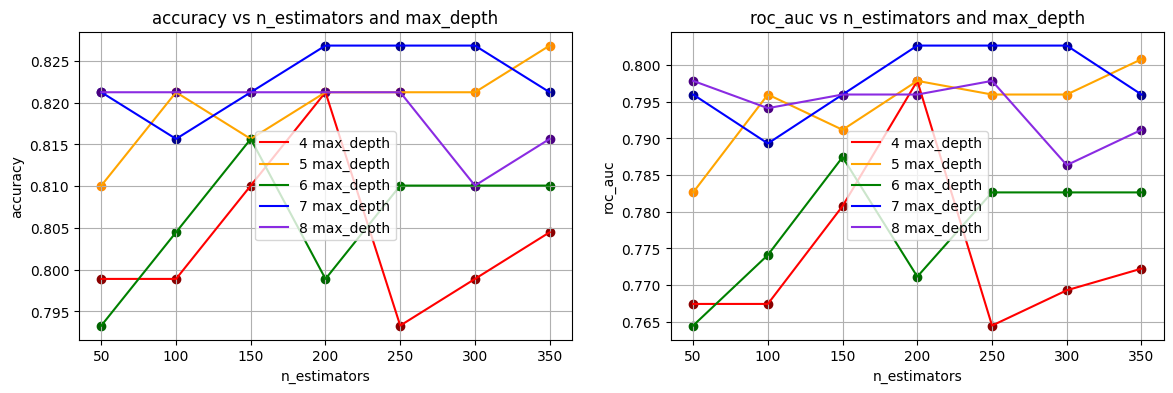

In [358]:
plot_global_data(global_dataFrame, 'n_estimators', 'max_depth')

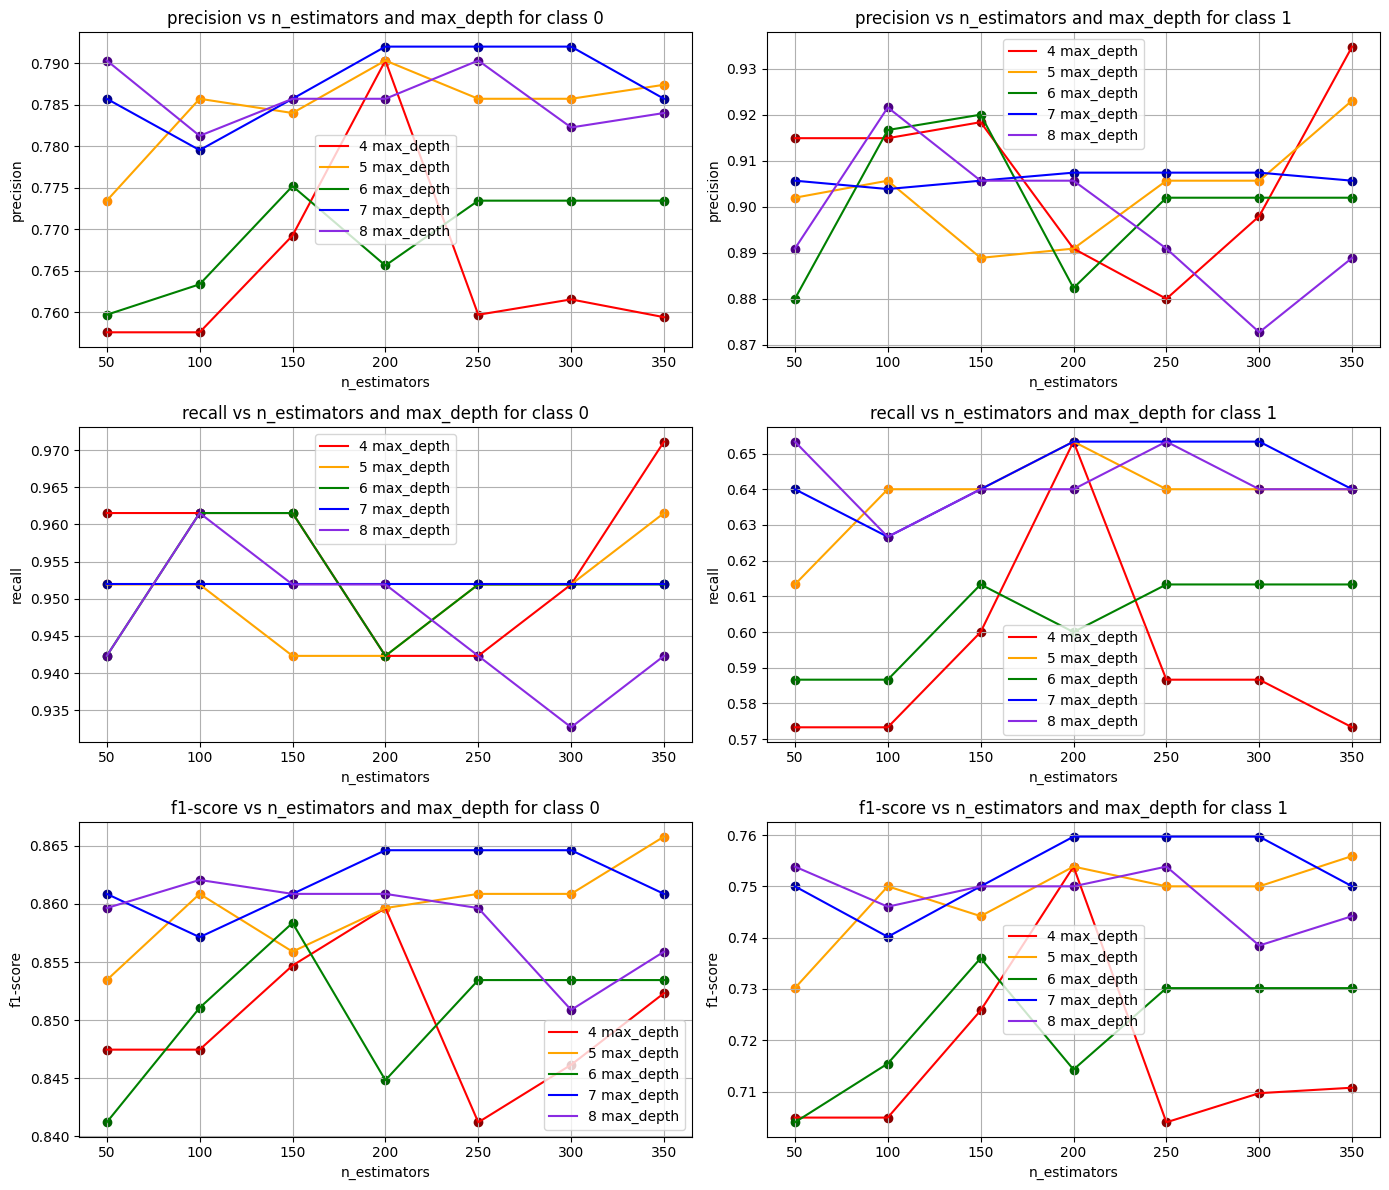

In [359]:
plot_per_class_data(per_class_dataFrame, 'n_estimators', 'max_depth')

Trochę trudne się wylosowało ... <br>
Jak widać na powyższych wykresach ... albo właśnie nie widać (oof) wyraźnego trendu dla żadnej z metryk xD. Gdyby się doszukiwać jakiś zależności to na ogół drzewo o max_depth równym 7 zdaje się osiągać najlepsze wyniki, a gdyby przyjąć konkretną liczbę drzew i badać max_depth to optymalnym przedziałem zdaje się być od 150 do 200 drzew.

---
i na deser MLP... badanie tego modelu obejmowało activation oraz solver.

In [360]:
MLP_model = MLPClassifier(
    activation='tanh',
    solver='sgd',
    hidden_layer_sizes=(100, 50, 25),
    random_state=42,
    max_iter=1000
)
activation = {'activation' : ['identity', 'logistic', 'tanh', 'relu']}
solver = {'solver' : ['sgd', 'adam']}
per_class_dataFrame, global_dataFrame = grid_search_function(MLP_model, X_train, X_test, y_train, y_test, activation, solver)

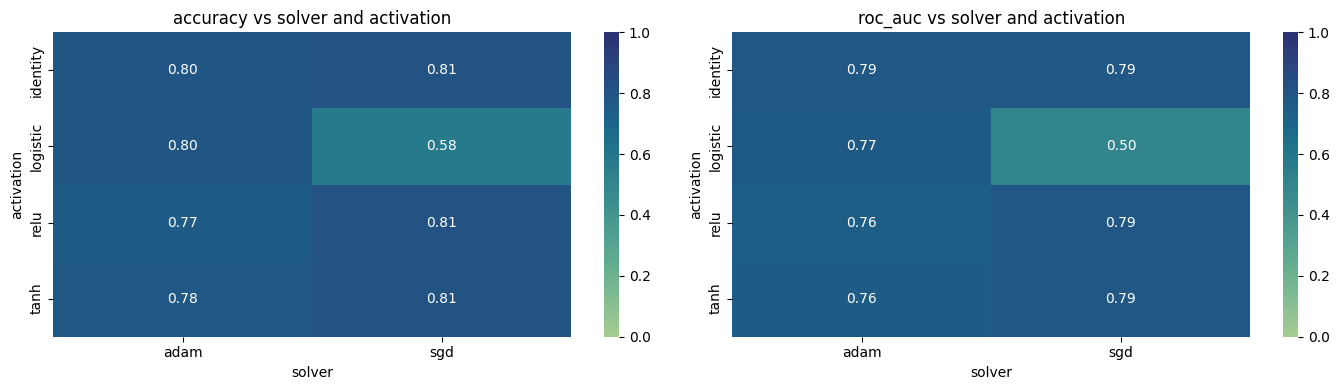

In [361]:
metrics = ['accuracy', 'roc_auc']

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for i, metric in enumerate(metrics):
    pivot_table = global_dataFrame.pivot(
        index="activation", columns="solver", values=metric)
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="crest", ax=axes[i], vmin=0, vmax=1)
    axes[i].set_title(f"{metric} vs solver and activation")

plt.tight_layout()
plt.show()

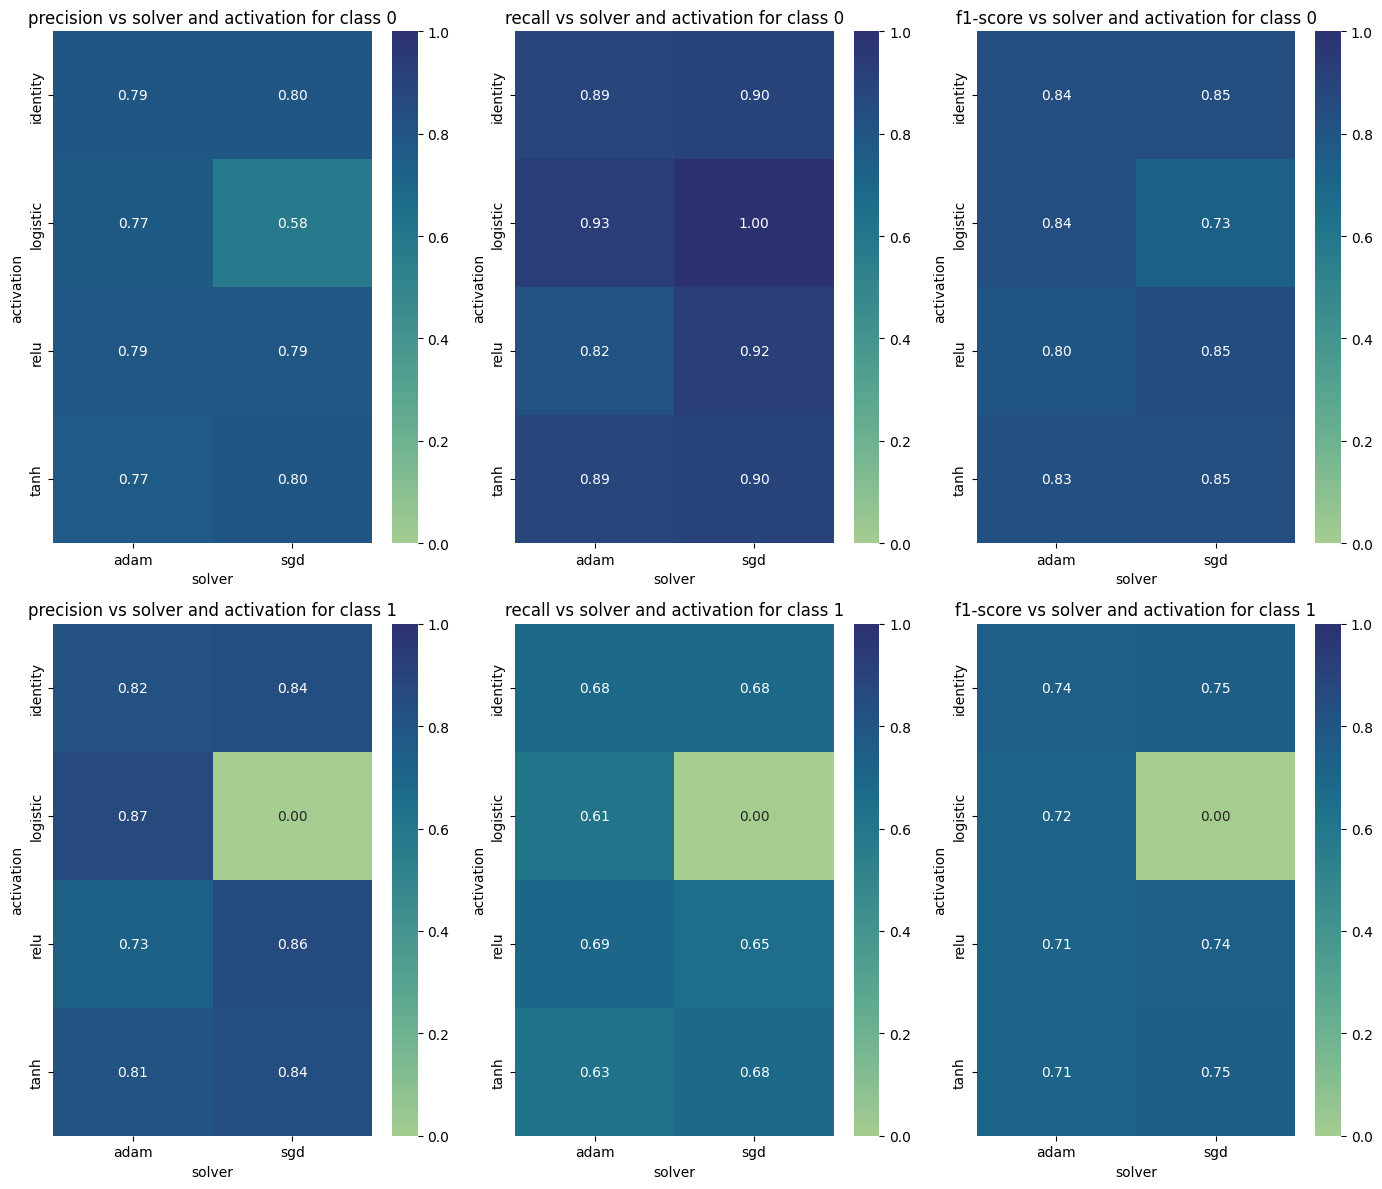

In [362]:
metrics = ['precision', 'recall', 'f1-score']

fig, axes = plt.subplots(2, 3, figsize=(14, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    pivot_table = per_class_dataFrame[per_class_dataFrame['class_id'] == '0'].pivot(
        index="activation", columns="solver", values=metric)
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="crest", ax=axes[i], vmin=0, vmax=1)
    axes[i].set_title(f"{metric} vs solver and activation for class 0")

    pivot_table = per_class_dataFrame[per_class_dataFrame['class_id'] == '1'].pivot(
        index="activation", columns="solver", values=metric)
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="crest", ax=axes[i+3], vmin=0, vmax=1)
    axes[i+3].set_title(f"{metric} vs solver and activation for class 1")

plt.tight_layout()
plt.show()

Jako że oba badane hiperparametry są dyskretne, to zamiast wykresu liniowego posłużyłem się heatmap'ą. <br>
Na powyższych wizualizacjach widać od razu, że połączenie sgd z logistic nie daje dobrych wyników. Przy takiej kombinacji model praktycznie nigdy nie trafia w klasę 1. Skąd to wynika to trudno mi powiedzieć. Z tego co wyczytałem to 'adam' ma bardziej adaptacyjny wskaźnik uczenia modelu, co daje większą stabilność procesu uczenia. 'sgd' natomiast wykorzystuje bardziej stały wskaźnik uczenia oraz małe serie danych w iteracyjnym uczeniu, więc wpływ tutaj może mieć niezbalansowanie klas w datasecie (jest więcej 0 niż 1 dla Survived). Ponadto 'sgd' jest podatne na wartość learning_rate_init, więc można byłoby to na przyszłość zbadać. <br>
Dla pozostałych funkcji aktywacji istotne cechy 'sgd' są już jednak zaletą, co zauważyć można po minimalnie lepszym wyniku 'sgd' nad 'adam' zwłaszcza w przypadku metryki F1.

---
Podsumowując, model XGB okazał się najbardziej stabilny z badanych modeli, co zauważyć można było po bardziej wyraźnych tendencjach w zależności od dobranych parametrów. W przypadku losowego lasu oraz KNN wyniki były bardziej chaotyczne, jednak przeważnie ich wynik był o zaledwie kilka procent gorszy od XGB. Natomiast wyniki dla MLP nie dają za dużo informacji. Prawdopodobnie przeoczone były inne bardziej istotne hiperparametry takie jak np.: learnign_rate_init.

---
Jeszcze na zakończenie o wyborze wizualizacji. Mogłem wybrać np.: dla XGB jakąś ładniejszą wizualizacje typu plot_surface, jednak nie byłoby widać niektórych danych, z uwagi na kształt powierzchni, dlatego tak samo jak w przypadku reszty modeli pozostałem przy wizualizacjach 2D :) <br>
Poniżej podaję przykład tego jak wyglądałyby wizualizacje plot_surface w przypadku XGB, gdybym się na nie zdecydował.

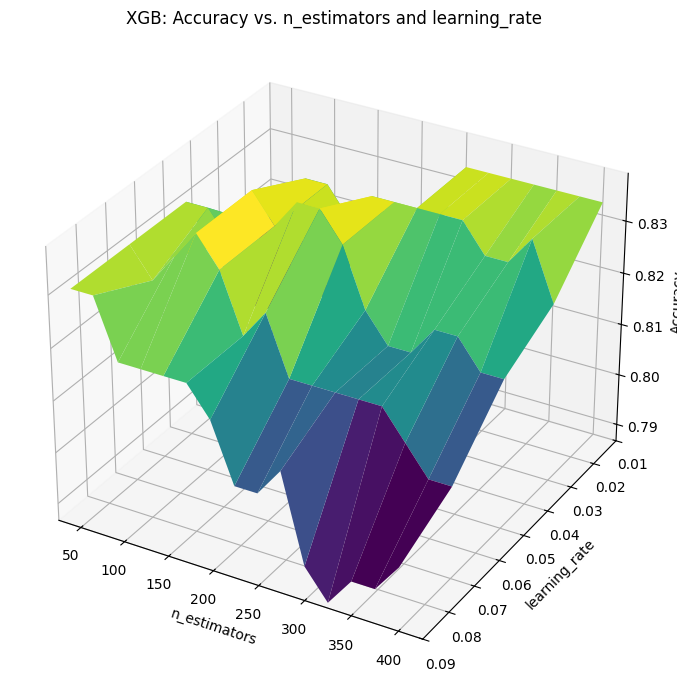

In [367]:
accuracy_pivot = global_dataFrame.pivot(index='n_estimators', columns='learning_rate', values='accuracy')

X = accuracy_pivot.index.values
Y = accuracy_pivot.columns.values
x, y = np.meshgrid(X, Y, indexing='ij')

z = accuracy_pivot.values

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')
ax.set_ylim(np.max(y), np.min(y))

ax.set_title('XGB: Accuracy vs. n_estimators and learning_rate')
ax.set_xlabel('n_estimators')
ax.set_ylabel('learning_rate')
ax.set_zlabel('Accuracy')

plt.tight_layout()
plt.show()